# High Value Customer Identification (Insiders)

# 0.0 Planejamento da Solução (IOT)

## Input (Entrada)

**1. Problema de Negócio**
* Selecionar os clientes mais valiosos para integrar um programa de fidelização.

**2. Conjunto de Dados**
* Vendas de um e-commerce online, durante o período de um ano (Nov 2015 - Dez 2017)

## Output (Saída)

**1. A indicação das pessoas que farão parte do programa de fidelização**
* Lista: com client_id | is_insider

**2. Relatório com as respostas para as perguntas de negócio**
* Quem são as pessoas elegíveis para participar do programa de Insiders?
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento, vida dos Insiders?
* Qual a expectativa de faturamento desse grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
* Quais as condições para uma pessoa ser removida dos Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de Marketing pode tomar para aumentar o faturamento?

## Tasks (Tarefas)

**1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

O que é ser elegível?

O que são clientes de maior "valor"?
- Faturamento
    * Alto ticket médio
    * Alto LTV (LifeTime Value)
    * Baixa Recência
    * Alto Basket size
    * Baixa probabilidade de Churn
    * Previsão de LTV
    * Alta propensão de compra
- Custo
    * Baixa taxa de devolução
- Experiência de compra
    * Média alta das avaliações

**2. Quantos clientes farão parte do grupo?**
- Número total de clientes
- % do grupo Insiders

**3. Quais as principais características desses clientes?**

* Escrever características dos clientes
    - Idade
    - Localização
* Escrever características do hábito de consumo
* Atributos da clusterização

**4. Qual a porcentagem de contribuição do faturamento, vida dos Insiders?**

* Faturamento total do ano
* Faturamento do grupo Insiders

**5. Qual a expectativa de faturamento desse grupo para os próximos meses?**

* LTV do grupo Insiders
* Análise de Cohort

**6. Quais as condições para uma pessoa ser elegível ao Insiders?**

* Definir a periodicidade
* A pesso precisa ser disimilar com uma pessoa do grupo

**7. Quais as condições para uma pessoa ser removida dos Insiders?**

* Definir a periodicidade
* A pesso precisa ser similar/parecida com uma pessoa do grupo

**8. Qual a garantia que o programa Insiders é melhor que o restante da base?**
* Teste A/B
* Teste A/B Bayesiano
* Teste de Hipóteses

**9. Quais ações o time de Marketing pode tomar para aumentar o faturamento?**
* Desconto
* Preferência de compra
* Frete
* Visita a empresa

## Benchamarking de soluções

### 1. Desk Research

**RFM Model**

_Recency_
* Tempo desde a última compra
* Responsividade

_Frequency_
* Tempo médio entre as transações
* Engajamento

_Monetary_
* Total gasto, faturamento
* "High-Value Purchases"

Modelo muito tradicional para empresas que tem CRM (Customer Relationship Management)

# 0.0 IMPORTS

In [65]:
import re
import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling   import ProfileReport

from sklearn    import cluster       as c
from sklearn    import metrics       as m
from plotly     import express       as px
from matplotlib import pyplot        as plt
from sklearn    import preprocessing as pp
from sklearn    import decomposition as dc
from sklearn    import ensemble      as en
from sklearn.manifold import TSNE

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def descriptive_analysis(num_attributes):
    # Tendência Central - média, mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # Concate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
    
    return m

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [5]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
data_raw = data_raw.drop(columns=['Unnamed: 8'])

In [6]:
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = data_raw

## 1.1 Rename columns

In [8]:
# Columns names in snake case
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']

# Renaming columns
df1.columns = cols_new

## 1.2 Data dimensions

In [9]:
# Information about shape
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 541909
Number of columns: 8


## 1.3 Data types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [11]:
# Sum of null values
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [12]:
# Separating null values for customer id
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [13]:
# Search for corresponding customer ids through invoice number
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


### Creating Customer ID

In [14]:
# Creating reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# Merging dataframes
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [15]:
# Changing date time
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# Changing customer id to integer
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descripte Statistics

In [16]:
# Separating numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
descriptive_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'> Numerical Attributes - Investigating </font>

**Quantity** negativa (pode ser devolução)

**Quantity** max - muito alta

**Unit_price** com mínimo negativo

### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.sample(10)

,invoice_no,stock_code,description,country
80188,543022,48194,DOORMAT HEARTS,United Kingdom
533929,581125,21090,SET/6 COLLAGE PAPER PLATES,United Kingdom
132861,547703,21670,BLUE SPOT CERAMIC DRAWER KNOB,Spain
231601,557274,22193,RED DINER WALL CLOCK,United Kingdom
183710,552667,22845,VINTAGE CREAM CAT FOOD CONTAINER,United Kingdom
449192,575087,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,United Kingdom
198166,554016,21930,JUMBO STORAGE BAG SKULLS,United Kingdom
249334,558904,21850,BLUE DIAMANTE PEN IN GIFT BOX,United Kingdom
425194,573311,22352,LUNCH BOX WITH CUTLERY RETROSPOT,United Kingdom
107947,545471,84991,60 TEATIME FAIRY CAKE CASES,United Kingdom


### <font color='red'> Categorical Attributes - Investigating </font>
**Invoice_no** com letras

**Stock_code** com letras

**Country** tem países fora do padrão

### **Invoice_no** com letras

In [19]:
# Invoice no
# some invoices have letters
invoices_with_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

negative_quantity = invoices_with_letters[invoices_with_letters['quantity'] < 0]

if len(invoices_with_letters) == len(negative_quantity):
    print('Todos os invoices com letras apresentam quantity negativa')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')
else:
    print('Não são todos os invoices com letras que apresentam quantity negativa')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')

Não são todos os invoices com letras que apresentam quantity negativa
# invoices: 9291
# negative quantity: 9288


### Stock_code com letras

In [20]:
# Stock code only characters
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Ação 1: Remover stock_code com ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

### Description

Ação: Deletar coluna 'description'

### Country

In [21]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


European Community/Unspecified: Não há indicativo aparente de países que englobam essa categoria

Ação: Padronizar os nomes dos países

# 2.0 FILTRAGEM DAS VARIÁVEIS

In [23]:
df2 = df1.copy()

In [24]:
# unit_price
df2 = df2[df2['unit_price'] > 0.04]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2[df2['quantity'] < 0]
df2_purchases = df2[df2['quantity'] >= 0]

# 3.0 FEATURE ENGINEERING

In [25]:
df3 = df2.copy()

## 3.1 Feature Creation

In [26]:
# Creating a dataframe with unique customer ids
df_ref = pd.DataFrame({'customer_id': df3['customer_id']}).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [27]:
# Creating RFM features
# Gross Revenue (quantity * unity price)
df2_purchases['gross_revenue'] = df2_purchases['quantity']*df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_13003/2981128415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases['gross_revenue'] = df2_purchases['quantity']*df2_purchases['unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day From Last Purchase

In [28]:
# Recency - Last Day Purchase for each customer
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# Calculating number of days since last purchase
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

# Merging dataframes
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of Purchases

In [29]:
# Number of purchases
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':
                                                                                                                       'qty_invoices'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

### 3.1.4 Quantity of Products Purchased

In [30]:
# Number of products purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qty_products'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
dtype: int64

### 3.1.5 Quantity of Items Purchased

In [31]:
# Number of items purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qty_items'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
dtype: int64

### 3.1.6 Average Ticket Value

In [32]:
# Avg Ticket
df_ticket = df2_purchases[['customer_id',
                           'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
avg_ticket       91
dtype: int64

### 3.1.7 Average Recency Days

In [33]:
# Shifting date invoice to calculate recencey between purchases
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id',
                                                                             'invoice_date'], ascending=[False, False])
# Next Customer
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
# Next Invoice date
df_aux['previous_date'] = df_aux['invoice_date'].shift()

# Calculating days between purchases
df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']).days
                                          if (x['customer_id'] == x['next_customer_id']) else np.nan, axis=1 )

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# Average Recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_products          91
qty_items             91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8 Frequency

In [34]:
# Aggregating max, min, number of days and number of purchases
df_aux = df2_purchases[['customer_id',
                        'invoice_no',
                        'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date', 'max'),
                                                                                      min_ = ('invoice_date', 'min'),
                                                                                      days_ = ('invoice_date', 
                                                                                               lambda x: ((x.max() - x.min()).days)+1),
                                                                                      buy_ = ('invoice_no', 'count')
                                                                                      ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: (x['buy_']/x['days_'])
                                                      if x['days_'] != 0 else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_products          91
qty_items             91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9 Number of Returns

In [35]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 
                                                                                                                 'qt_returns'})

df_returns['qt_returns'] = df_returns['qt_returns']*-1

# Merging dataframes
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qt_returns'].isna(), 'qt_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_products          91
qty_items             91
avg_ticket            91
avg_recency_days    2816
frequency             91
qt_returns             0
dtype: int64

### 3.1.10 Basket Size

In [36]:
# Couting number of products per invoice
df_aux = df2_purchases.loc[:, ['customer_id',
                               'invoice_no', 
                               'quantity']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                       n_products = ('quantity', 'sum')
                                                                      ).reset_index()

# Calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# Merging dataframes
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')

# Checking for null values
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_products          91
qty_items             91
avg_ticket            91
avg_recency_days    2816
frequency             91
qt_returns             0
avg_basket_size       91
dtype: int64

### 3.1.11 Distinct Basket Products

In [37]:
# Number of distinct products per basket
# Couting number of products per invoice
df_aux = df2_purchases.loc[:, ['customer_id',
                               'invoice_no', 
                               'stock_code']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                         n_products = ('stock_code', 'nunique')
                                                                        ).reset_index()

# Calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# Merging dataframes
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')

# Checking for null values
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qty_invoices                91
qty_products                91
qty_items                   91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qt_returns                   0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [38]:
df4 = df_ref.dropna().copy()

## 4.1 Univariate Analysis

**Notes**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação
    - Distribuição

In [39]:
# # Pandas Profiling 
# profile = ProfileReport(df4)

# # Generating a html file
# profile.to_file('output.html')

### 4.1.1 Gross Revenue

Valores extremos muito acima do 95º percentil (7219.68).

In [40]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,avg_recency_days,frequency,qt_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,2060.0,196844.0,135.503893,7.844444,0.203390,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,431.0,64124.0,602.453132,14.680000,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,337.0,69993.0,577.302047,12.821429,0.127778,952.0,1521.586957,7.326087
3338,16446,168472.50,0.0,2.0,3.0,80997.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140438.72,1.0,199.0,5670.0,79963.0,24.768734,2.601399,0.533512,3332.0,401.824121,28.492462
1150,12415,124564.53,24.0,20.0,713.0,77373.0,174.704811,20.866667,0.063694,427.0,3868.650000,35.650000
190,14156,117375.63,9.0,55.0,1399.0,57785.0,83.899664,7.260000,0.151515,859.0,1050.636364,25.436364
15,17511,91062.38,2.0,31.0,963.0,64549.0,94.561142,11.593750,0.083333,1535.0,2082.225806,31.064516
12,16029,72882.09,38.0,62.0,241.0,40207.0,302.415311,9.054054,0.184524,8004.0,648.500000,3.887097
955,16684,66653.56,4.0,28.0,277.0,50255.0,240.626570,22.125000,0.078873,864.0,1794.821429,9.892857


### 4.1.2 Quantity of  Products

Valores extremos muito acima do 95º percentil (382).

In [41]:
df4.sort_values('qty_products', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,avg_recency_days,frequency,qt_returns,avg_basket_size,avg_unique_basket_size
68,17841,40959.72,1.0,124.0,7837.0,22853.0,5.226454,3.321429,0.332440,203.0,184.298387,63.201613
66,14911,140438.72,1.0,199.0,5670.0,79963.0,24.768734,2.601399,0.533512,3332.0,401.824121,28.492462
4406,14096,53258.43,4.0,17.0,5095.0,16336.0,10.453078,6.062500,0.173469,0.0,960.941176,299.705882
47,12748,32305.32,0.0,206.0,4577.0,25211.0,7.058187,3.330357,0.550802,1535.0,122.383495,22.218447
96,14606,12021.65,1.0,91.0,2698.0,6215.0,4.455764,4.275862,0.243968,245.0,68.296703,29.648352
8,15311,60767.90,0.0,91.0,2379.0,38194.0,25.543464,4.144444,0.243316,474.0,419.714286,26.142857
1017,14646,279138.02,1.0,72.0,2060.0,196844.0,135.503893,7.844444,0.203390,288.0,2733.944444,28.611111
278,13089,58825.83,2.0,97.0,1818.0,31070.0,32.357442,4.475610,0.263587,283.0,320.309278,18.742268
1398,13263,7443.85,1.0,35.0,1673.0,4774.0,4.449402,10.125000,0.107692,0.0,136.400000,47.800000
826,14298,51523.30,8.0,44.0,1636.0,58243.0,31.493460,14.280000,0.124646,322.0,1323.704545,37.181818


### 4.1.3 Avg Ticket

Valores extremos muito acima do 95º percentil (90.497).
Observa-se que alguns clientes com ticket médio alto também fizeram muitas devoluções.

In [42]:
df4.sort_values('avg_ticket', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,avg_recency_days,frequency,qt_returns,avg_basket_size,avg_unique_basket_size
3338,16446,168472.50,0.0,2.0,3.0,80997.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
1262,15749,44534.30,235.0,3.0,10.0,18028.0,4453.430000,97.000000,0.030612,9014.0,6009.333333,3.333333
1820,18087,3202.92,290.0,1.0,1.0,3906.0,3202.920000,78.500000,1.000000,336.0,3906.000000,1.000000
1136,16532,6748.80,17.0,3.0,4.0,2016.0,1687.200000,160.500000,0.009317,0.0,672.000000,1.333333
601,12755,3811.95,280.0,2.0,4.0,1491.0,952.987500,58.000000,0.023256,624.0,745.500000,2.000000
3780,12798,6977.04,10.0,3.0,8.0,5256.0,872.130000,80.000000,0.018634,0.0,1752.000000,2.666667
249,17949,58030.48,1.0,44.0,69.0,30450.0,841.021449,13.214286,0.118598,2878.0,692.045455,1.568182
186,15299,3907.01,67.0,6.0,6.0,2947.0,651.168333,101.666667,0.019608,5.0,491.166667,1.000000
2548,16308,2560.00,37.0,4.0,4.0,8000.0,640.000000,74.666667,0.017778,0.0,2000.000000,1.000000
5406,16986,1873.20,29.0,2.0,3.0,1040.0,624.400000,1.000000,1.000000,0.0,520.000000,1.500000


### 4.1.4 Frequency

Há um cliente com frequência muito acima dos demais.

In [43]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_products,qty_items,avg_ticket,avg_recency_days,frequency,qt_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,297.0,1733.0,18.152222,35.5,17.0,40.0,50.970588,8.735294


In [45]:
# Looking at customer purchases
df2_purchases[df2_purchases['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850,15.30
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850,20.34
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850,22.00
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850,20.34
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850,20.34
...,...,...,...,...,...,...,...,...
4540,536790,22752,4,2016-11-30,7.65,United Kingdom,17850,30.60
4541,536790,22803,3,2016-11-30,35.75,United Kingdom,17850,107.25
4542,536790,21730,12,2016-11-30,4.25,United Kingdom,17850,51.00
4543,536791,22632,12,2016-11-30,1.85,United Kingdom,17850,22.20


### 4.1.* Ações:

- Remover os casos de devolução
- Criar features:
    * subtrair devoluções do número de itens comprados
    * dividir o número de itens comprados por devoluções (<0.5 significa que comprou mais que devolveu)
    * ticket médio e gross revenue calculados subtraindo o valor de devoluções

## 4.2 Bivariate Analysis

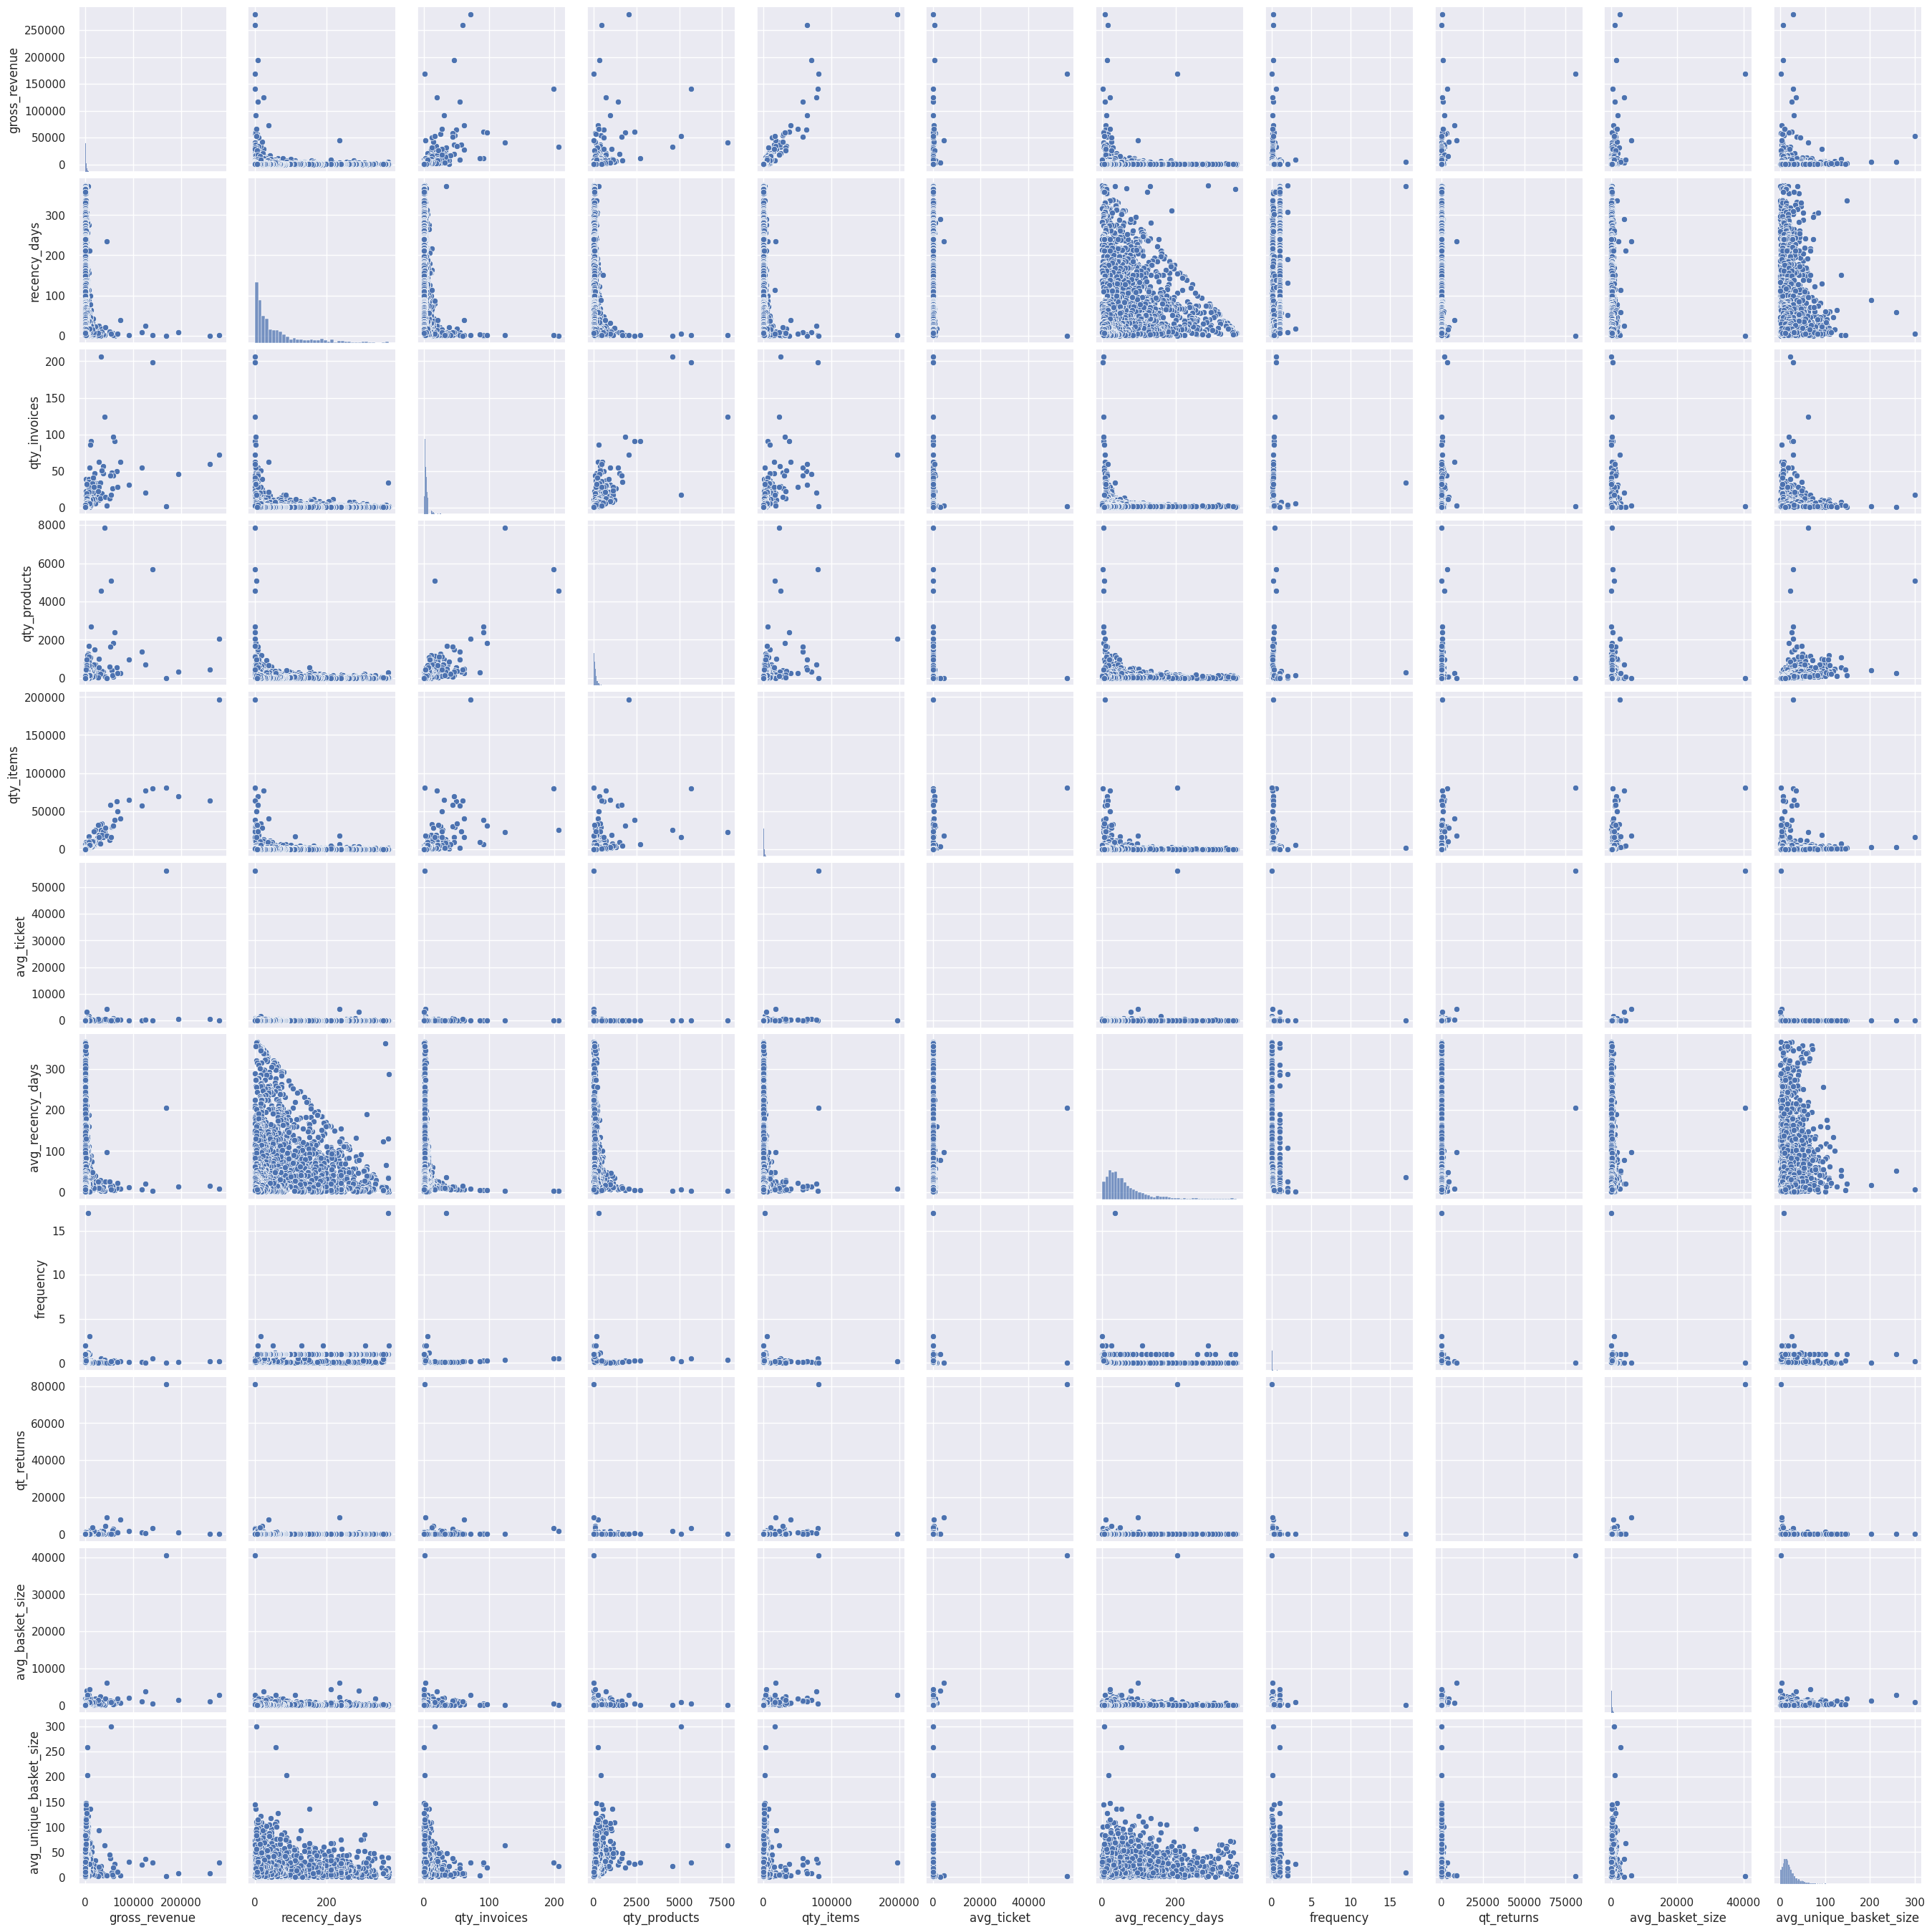

In [45]:
df_aux = df4.drop('customer_id', axis=1).copy()
sns.pairplot(df_aux)

## 4.3 Estudo do Espaço

In [56]:
df43 = df4.drop(columns=['customer_id'], axis = 1).copy()

### Encoding

In [57]:
# Encoding features with Min Max Scaler
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
df43['qty_invoices']           = mm.fit_transform(df43[['qty_invoices']])
df43['qty_products']           = mm.fit_transform(df43[['qty_products']])
df43['qty_items']              = mm.fit_transform(df43[['qty_items']])
df43['avg_ticket']             = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['qt_returns']             = mm.fit_transform(df43[['qt_returns']])
df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1 PCA

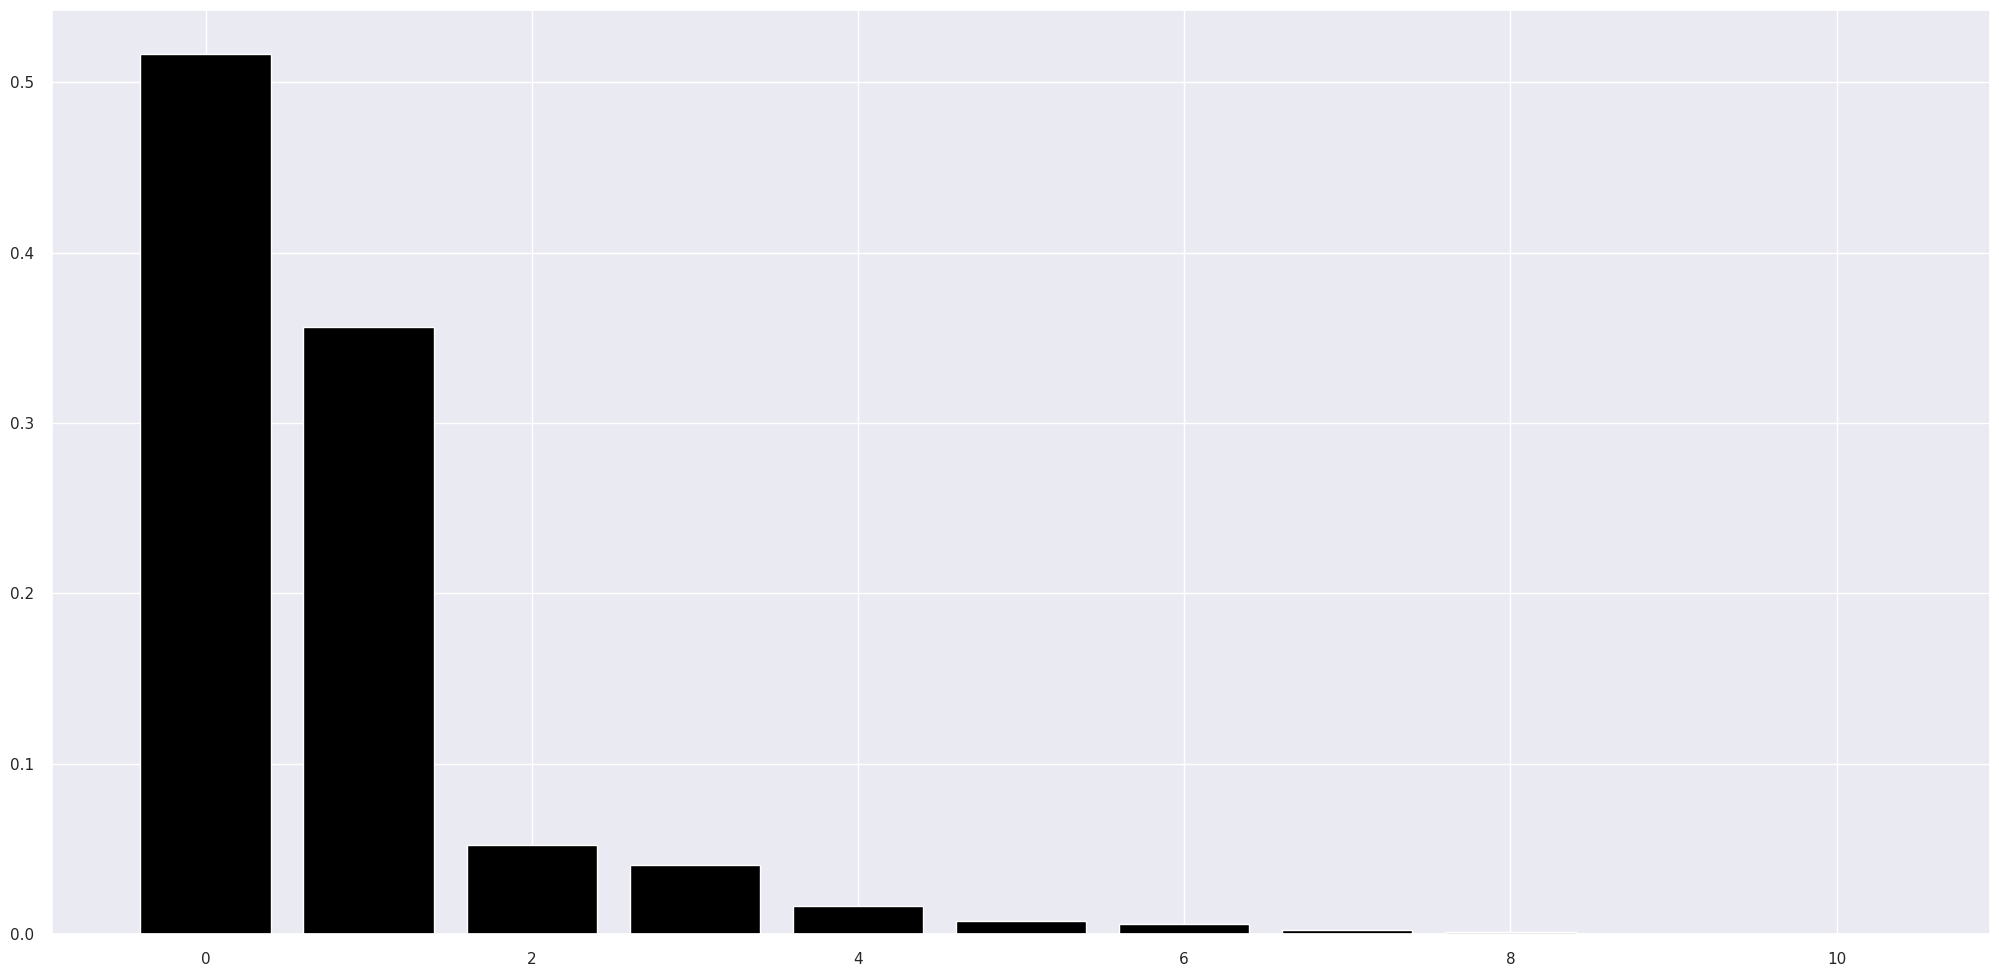

In [59]:
# Defining number o components for PCA as number of columns
pca = dc.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# Plot explained variables
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

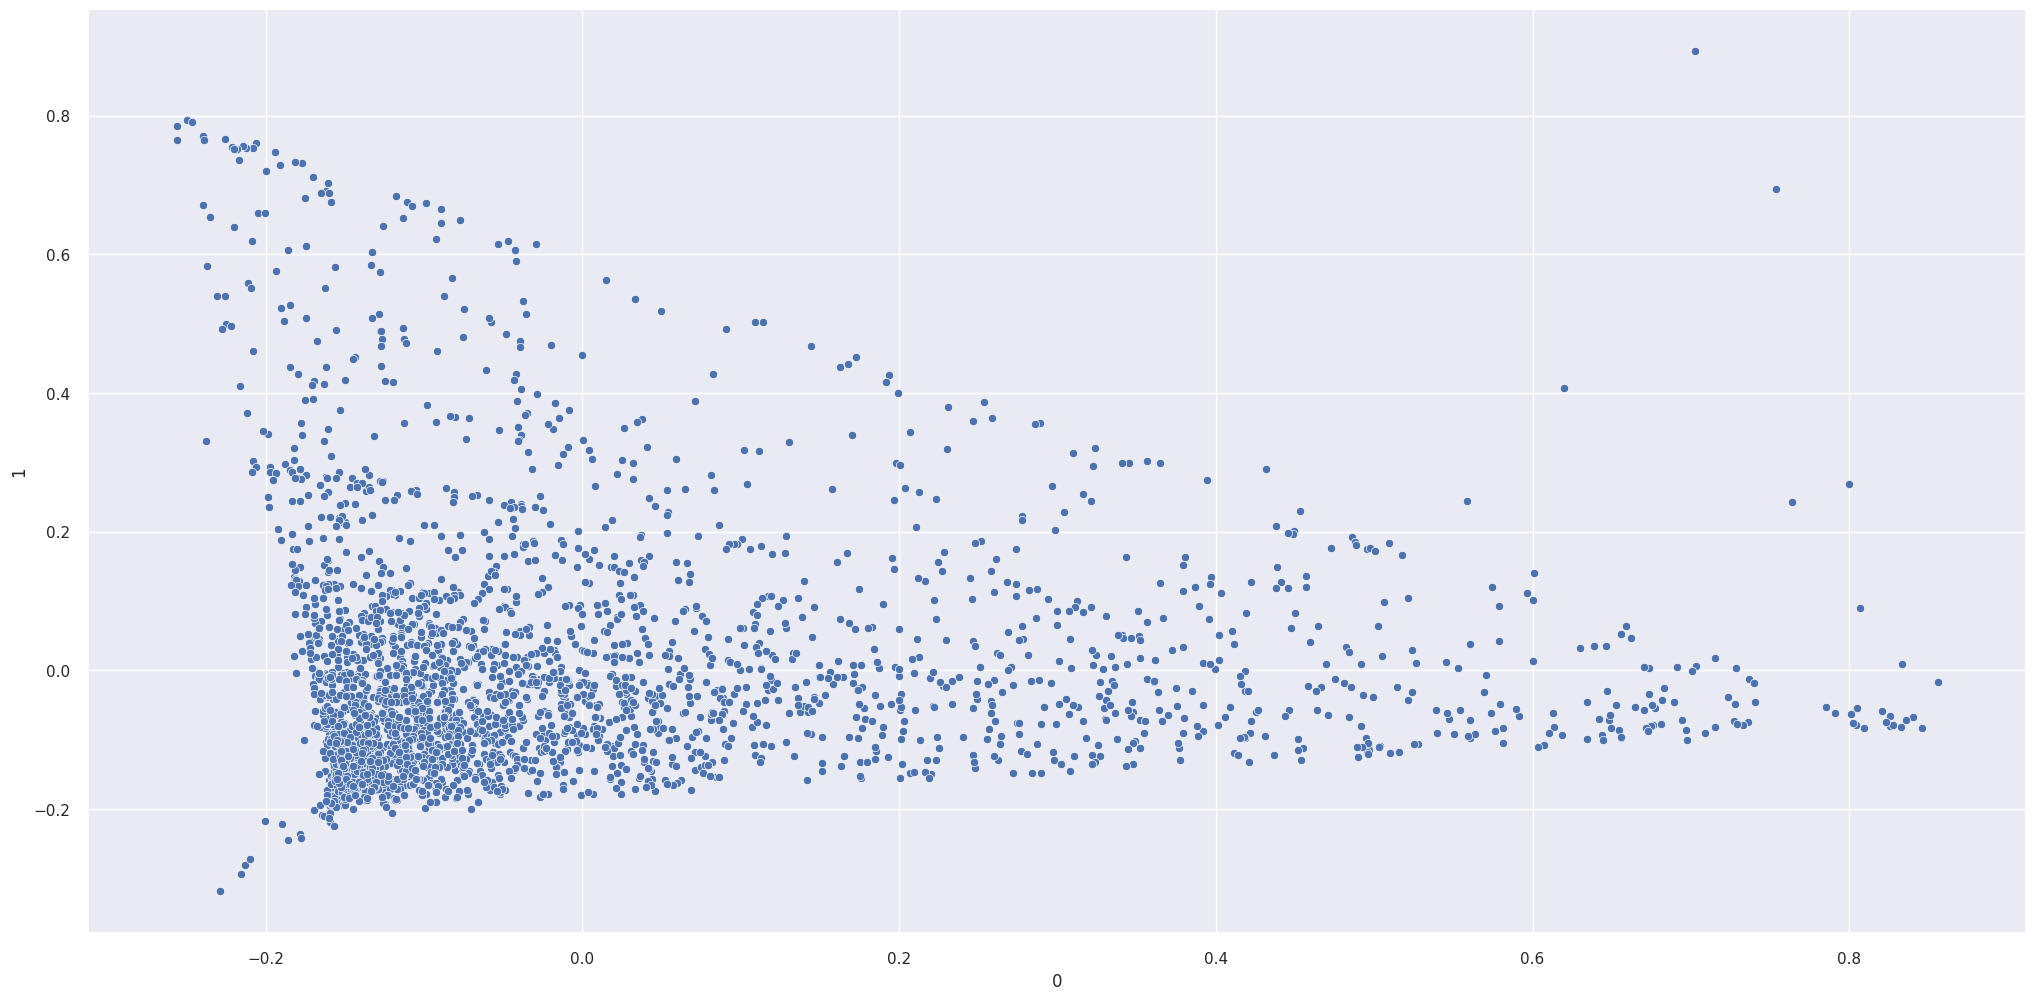

In [60]:
# Plot Component 0 and 1
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

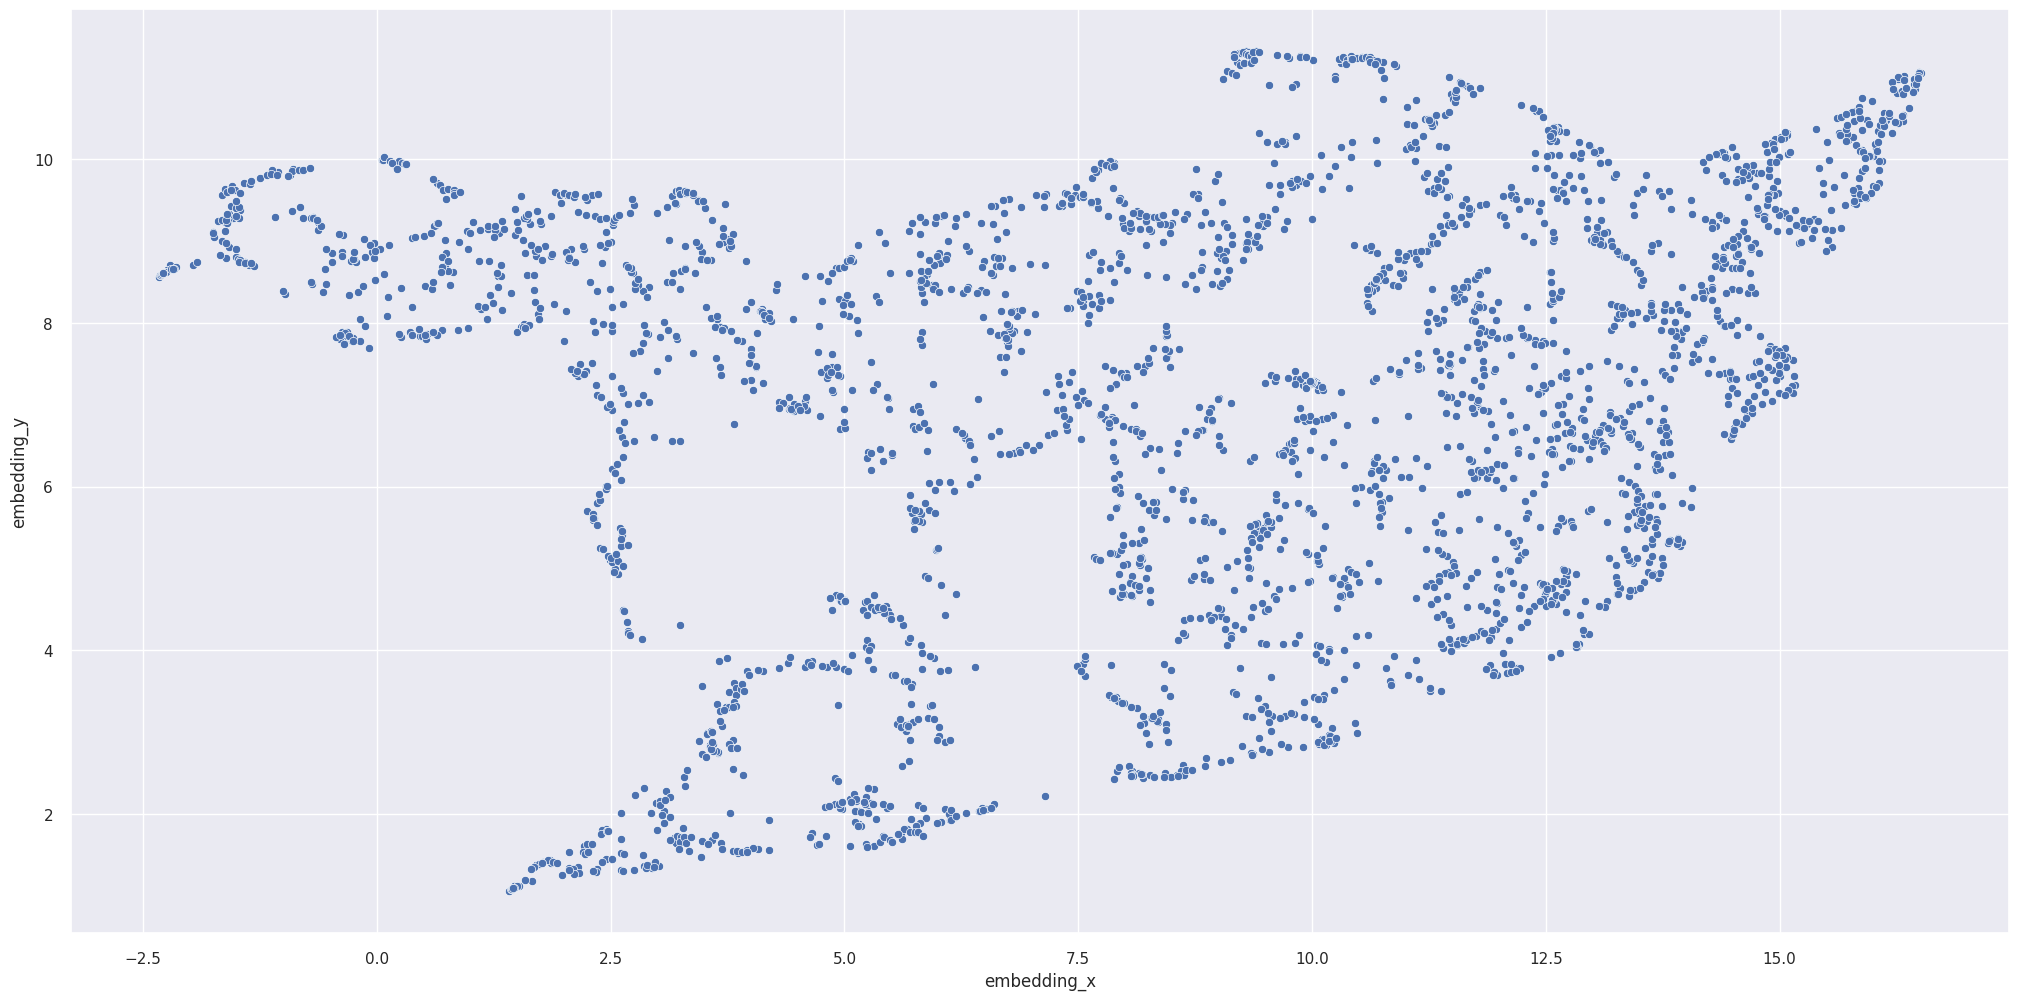

In [61]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

### 4.3.3 t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

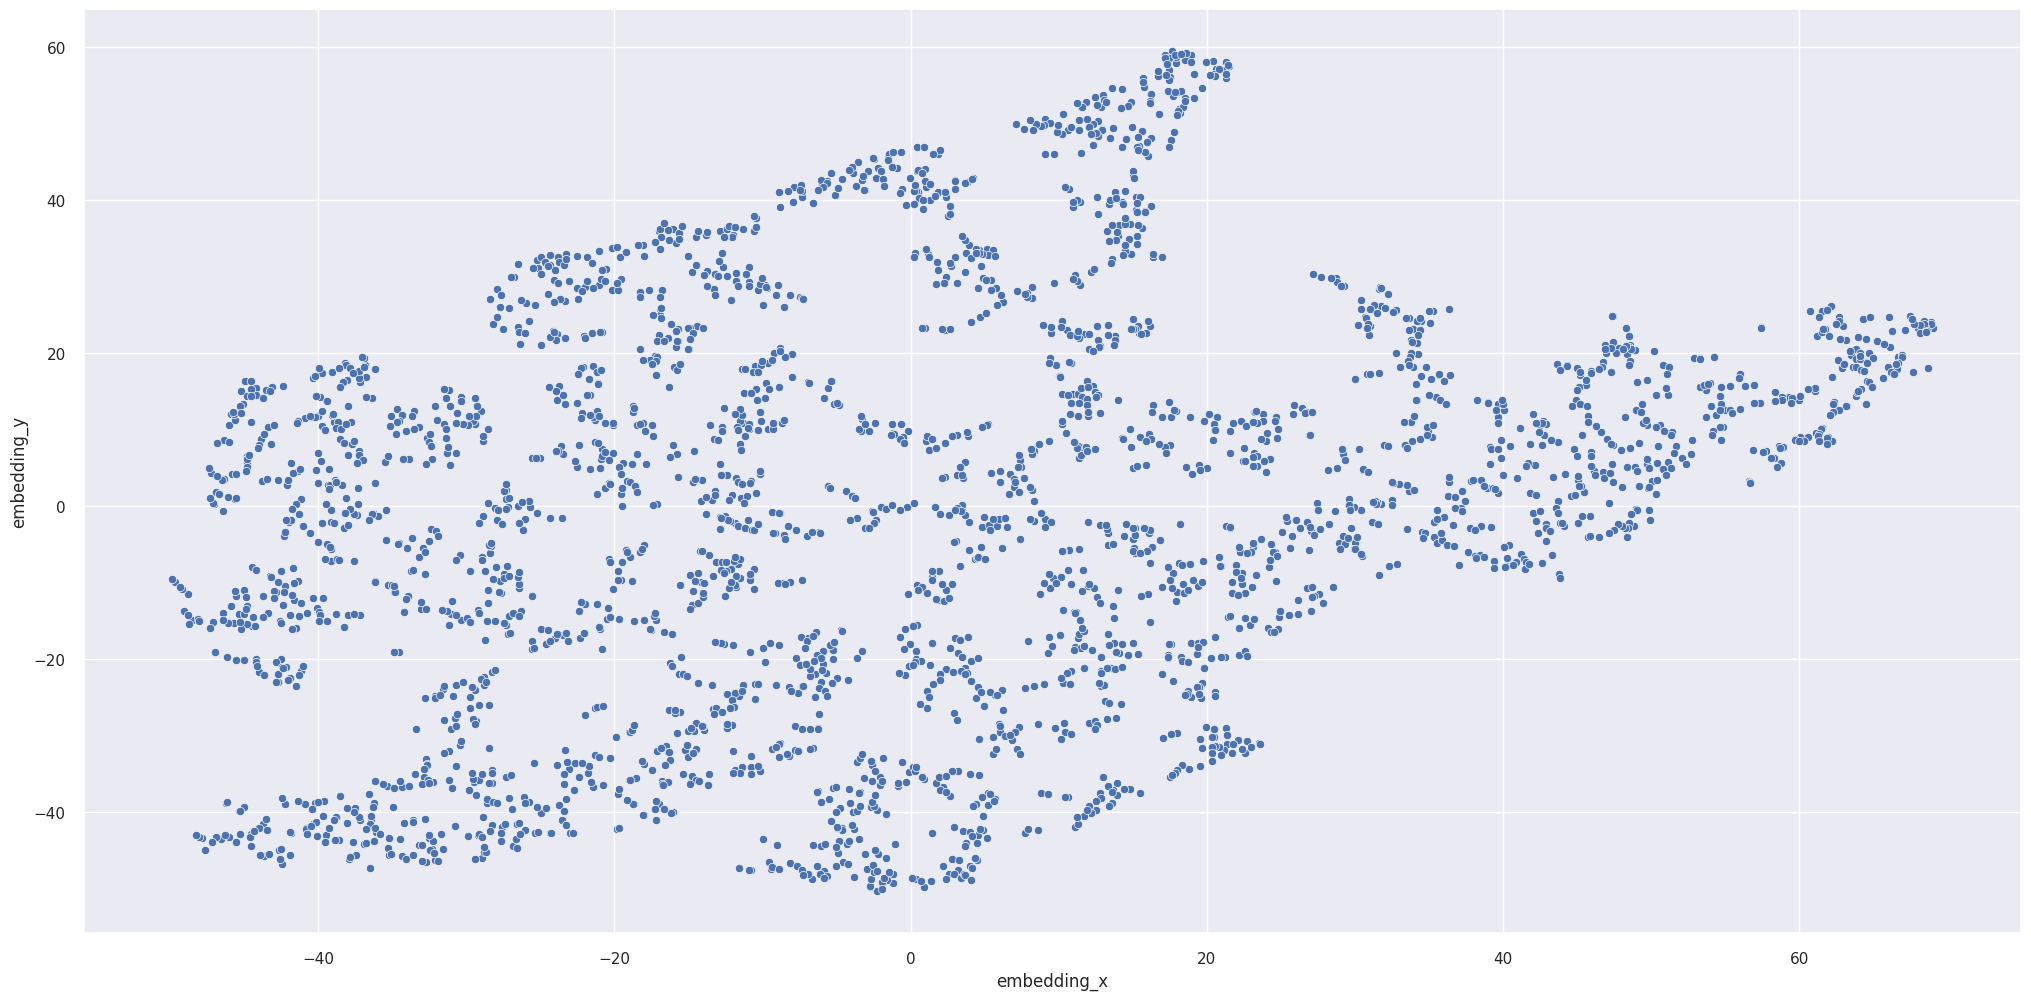

In [64]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

### 4.3.4 Tree-Based Embedding

In [68]:
# Decision Tree doesn't require Scalers
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)

# Defining Gross Revenue as target
y = df4['gross_revenue']

# Model definition
rf_model = en.RandomForestRegressor(n_estimators=1000, random_state=42)

# Model training
rf_model.fit(X, y)

# Leafs
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

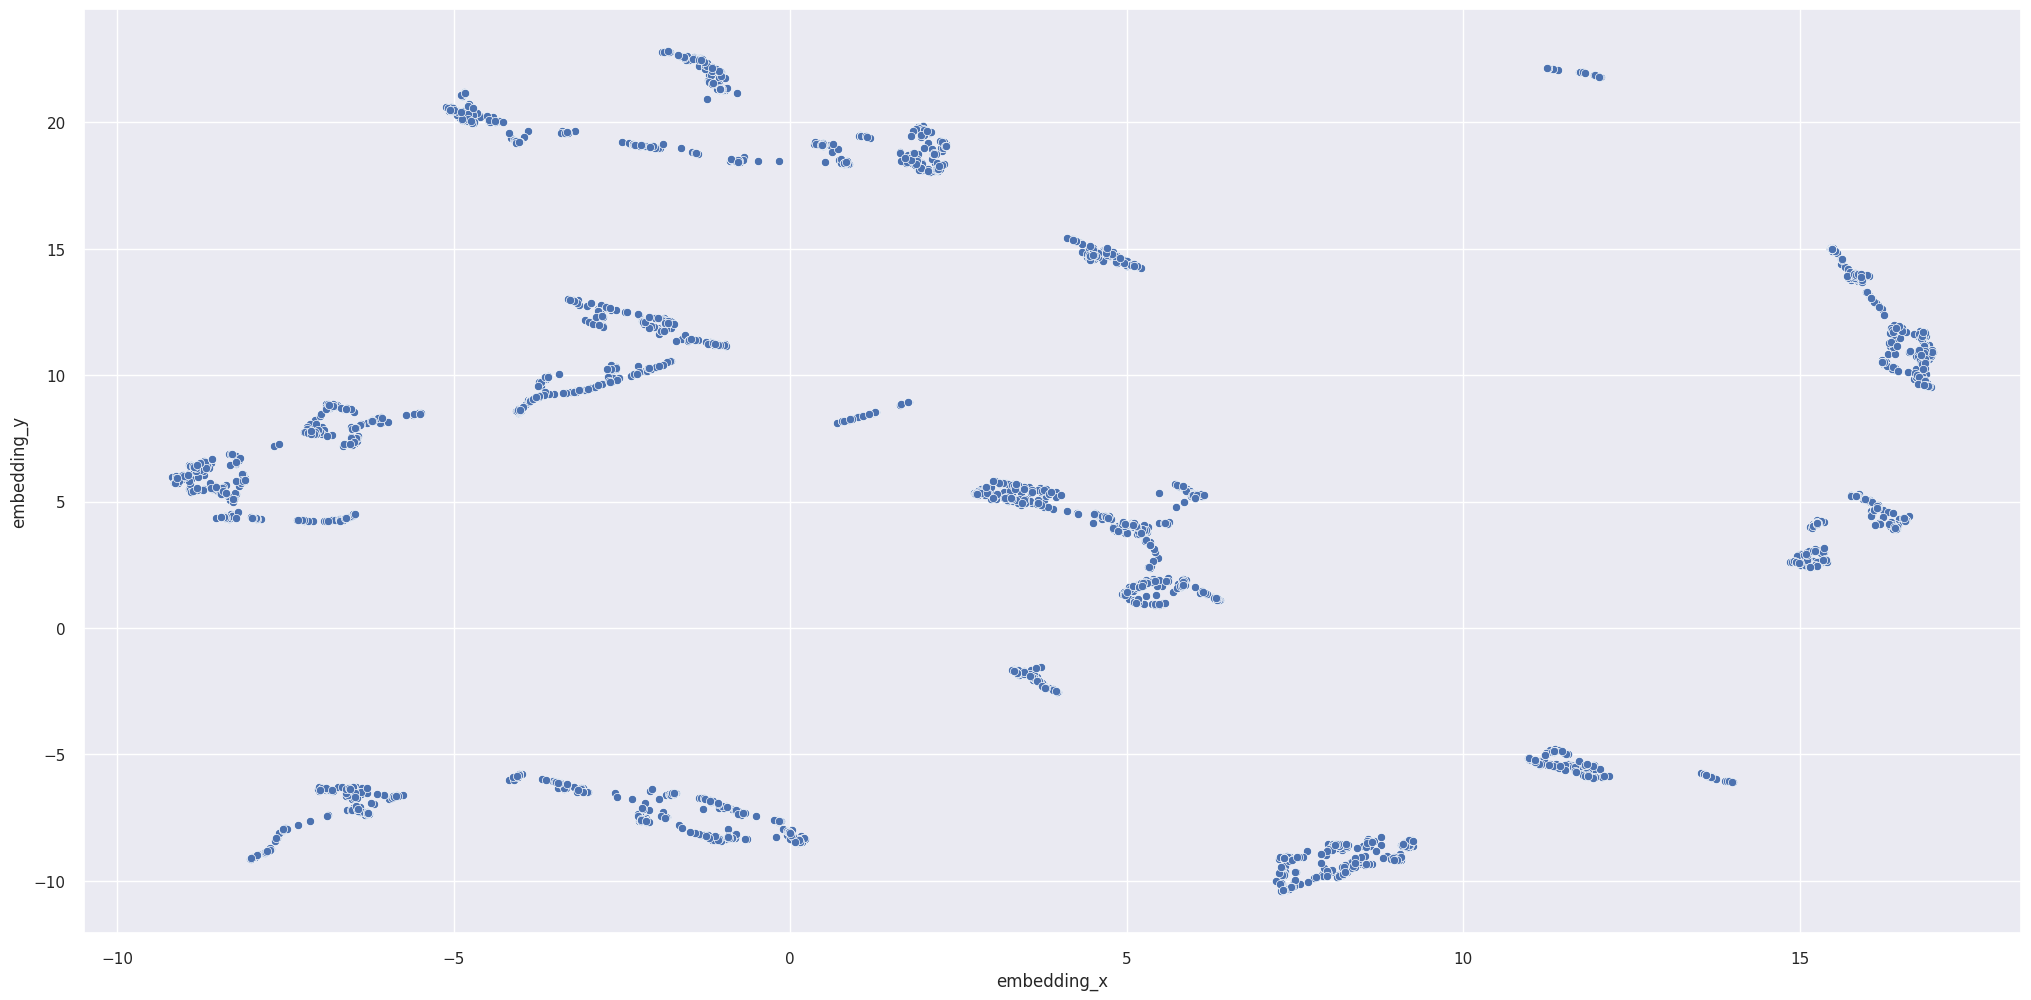

In [69]:
# with UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

# 5.0 DATA PREPARATION

In [50]:
df5 = df_ref.dropna().copy()

In [51]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

In [52]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377193,2.791512,3.889210,-0.033939
1,13047,0.135388,-0.361004,0.620928,-0.033427
2,12583,0.524404,-0.899726,1.405316,-0.026622
3,13748,-0.120499,0.028072,0.098003,-0.023244
4,15100,-0.128592,2.402435,-0.163459,0.152443


# 6.0 FEATURE SELECTION

Skipped in initial analysis

# 7.0 HYPERPARAMETER FINE-TUNNING 

In [53]:
df7 = df5.drop(columns=['customer_id'])

In [54]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

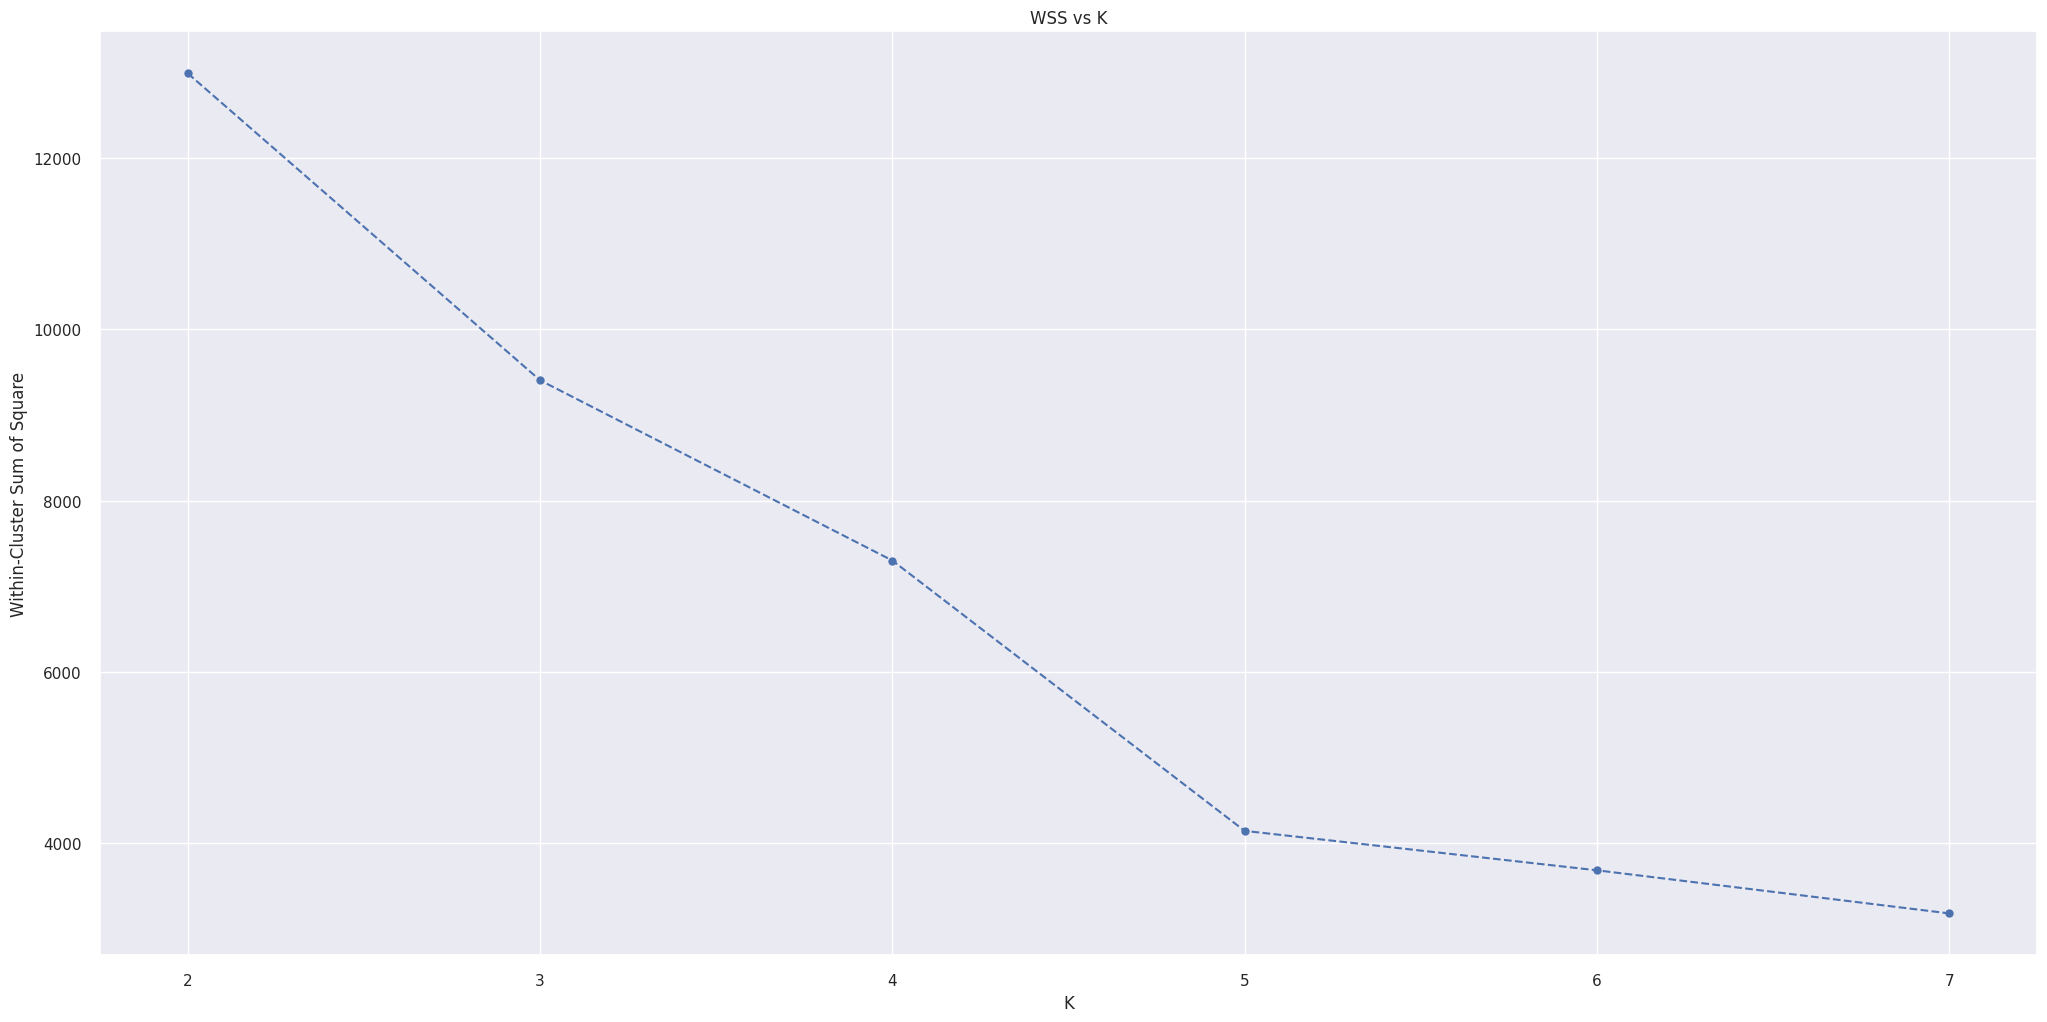

In [55]:
wss = []
for k in clusters:
    # Model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # Model training
    kmeans.fit(df7)
    
    # Validation
    wss.append(kmeans.inertia_)
    
# Ploting wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K');

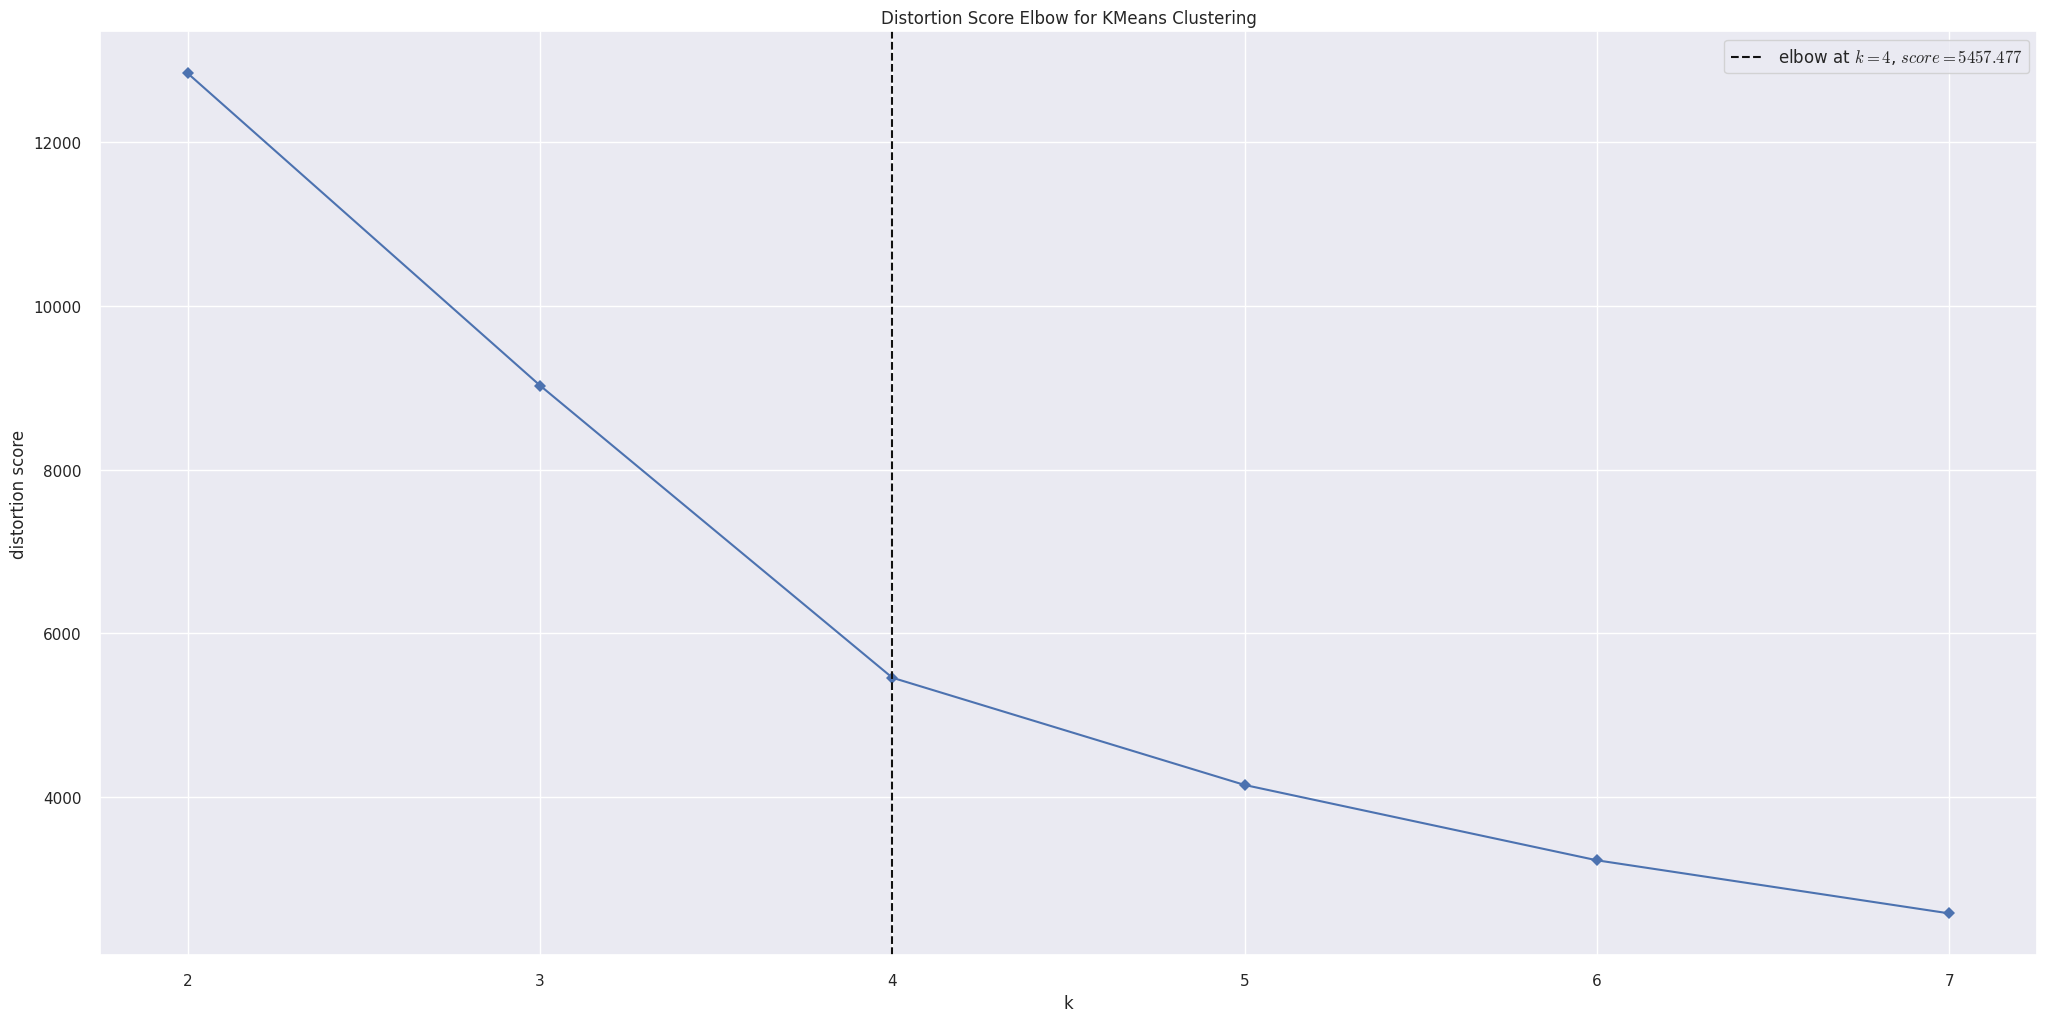

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
# Using Yellowbrick Visualizer
# Model definition
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, timings=False)

# Model training
kmeans.fit(df7)
kmeans.show()

## 7.2 Silhouette Score

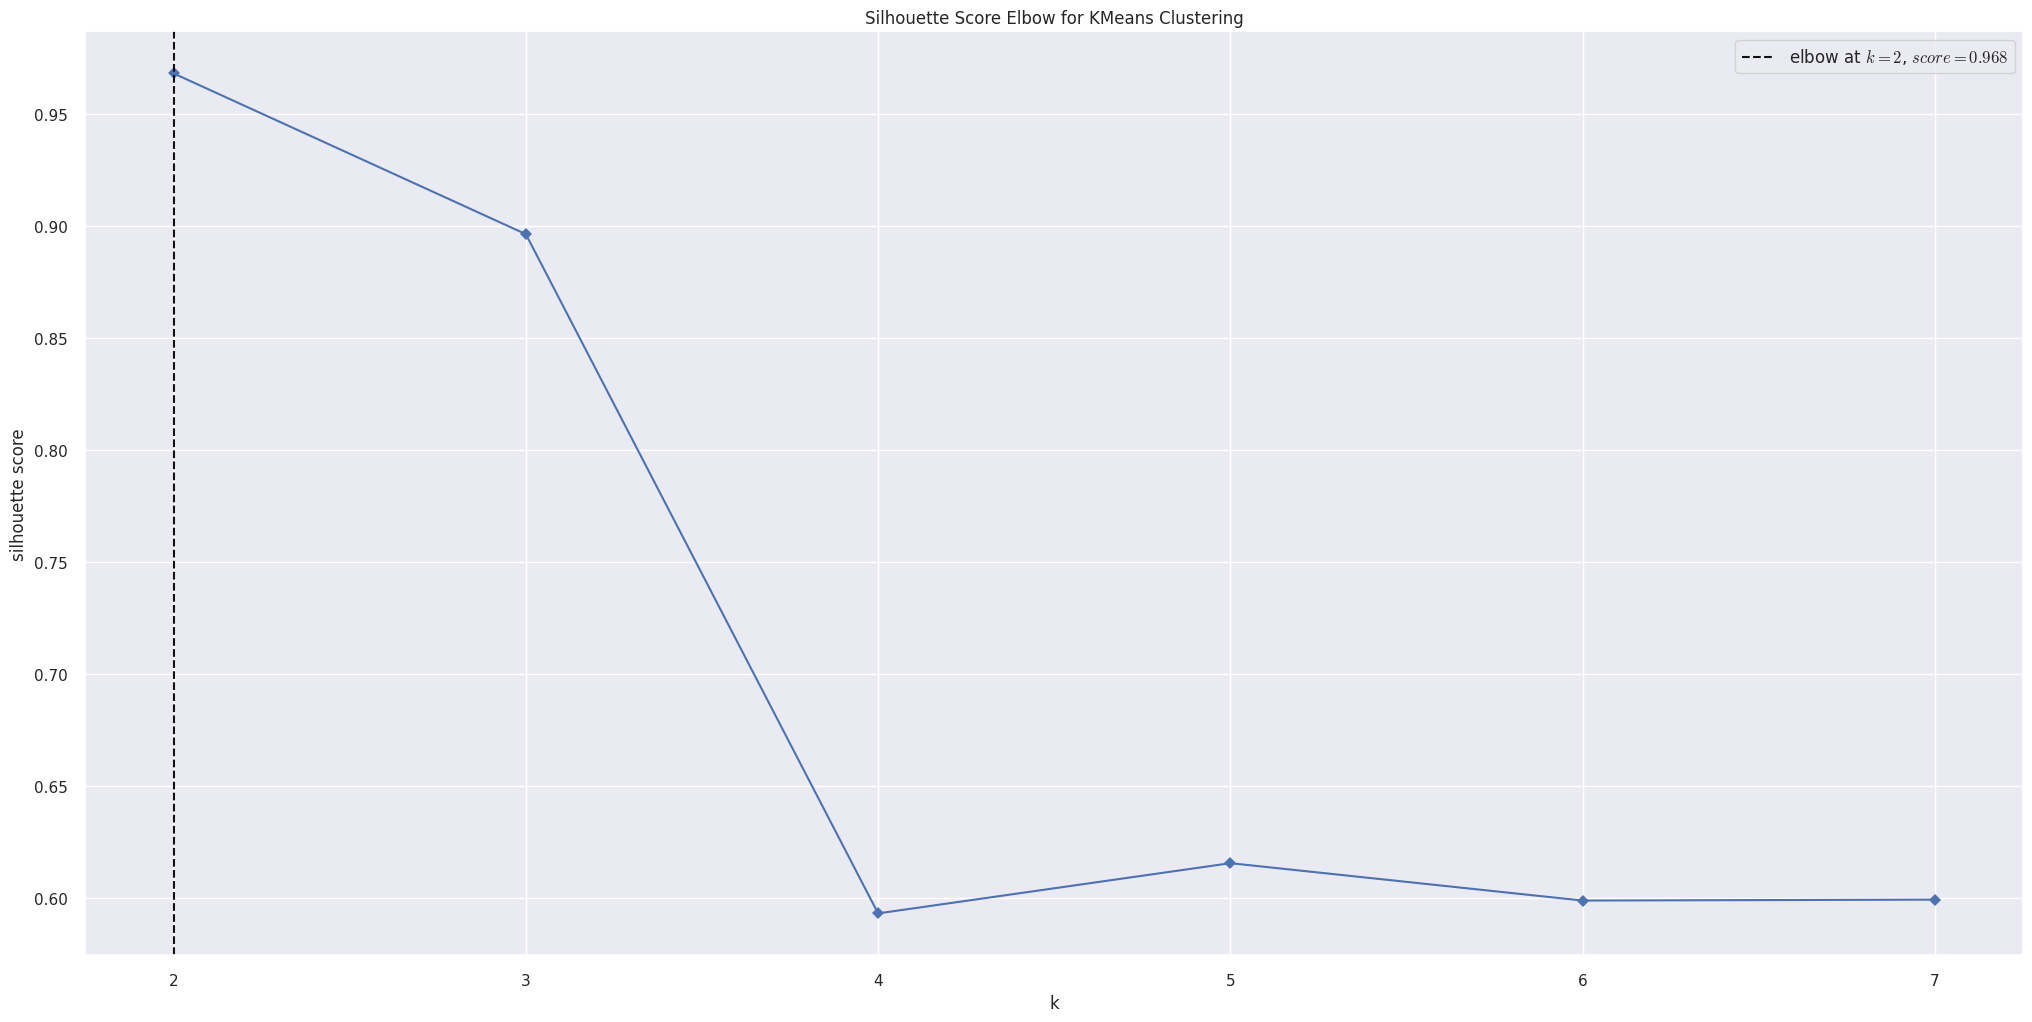

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [57]:
# Using Yellowbrick Visualizer
# Model definition
kmeans = KElbowVisualizer(c.KMeans(n_init=10), metric='silhouette', k=clusters, timings=False)

# Model training
kmeans.fit(df7)
kmeans.show()

## 7.3 Silhouette Analysis

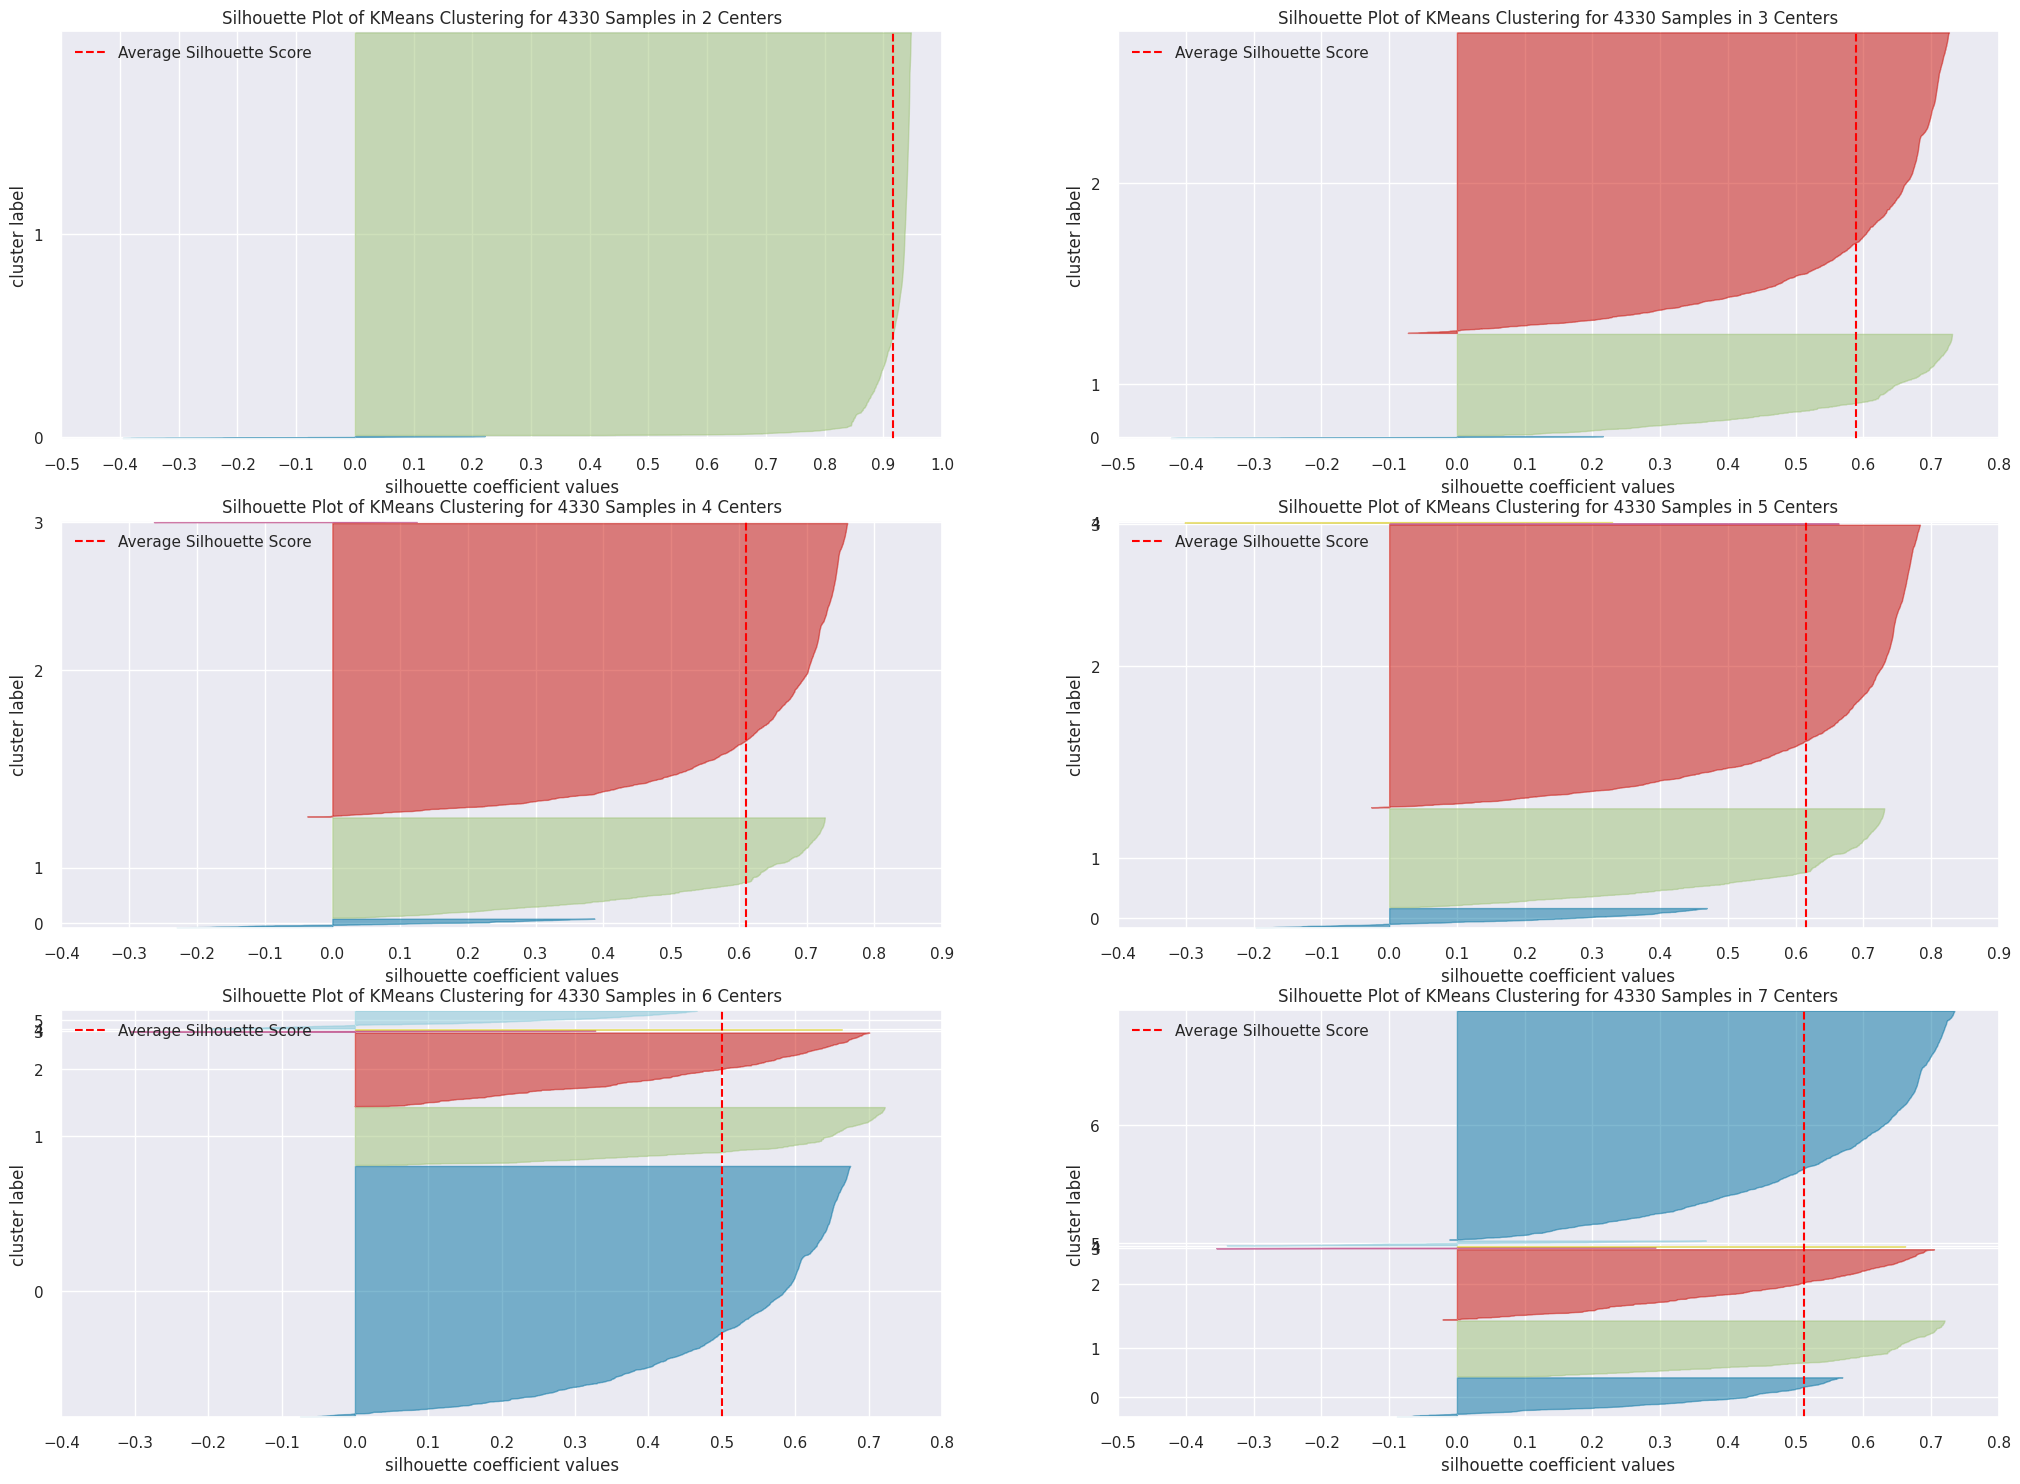

In [58]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))
                      
for k in clusters:
    # Model definition
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8.0 MODEL TRAINING

In [59]:
df8 = df7.copy()

## 8.1 K-Means

In [60]:
# Model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model training
kmeans.fit(df8)

# Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [61]:
# WSS (Within-Cluster Sum of Squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS value: 9404.957923270296
Silhouette Score: 0.5895242294229587


# 9.0 CLUSTER ANALYSIS

In [63]:
df9 = df_ref.dropna().copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5391.21,372.0,34.0,18.152222,1
1,13047,3232.59,56.0,9.0,18.904035,2
2,12583,6705.38,2.0,15.0,28.902500,2
3,13748,948.25,95.0,5.0,33.866071,2
4,15100,876.00,333.0,3.0,292.000000,1


In [ ]:
# Limited to 3 features
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

## 9.1 Visualization Inspection

/home/matheus/.pyenv/versions/3.8.12/envs/pa005/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


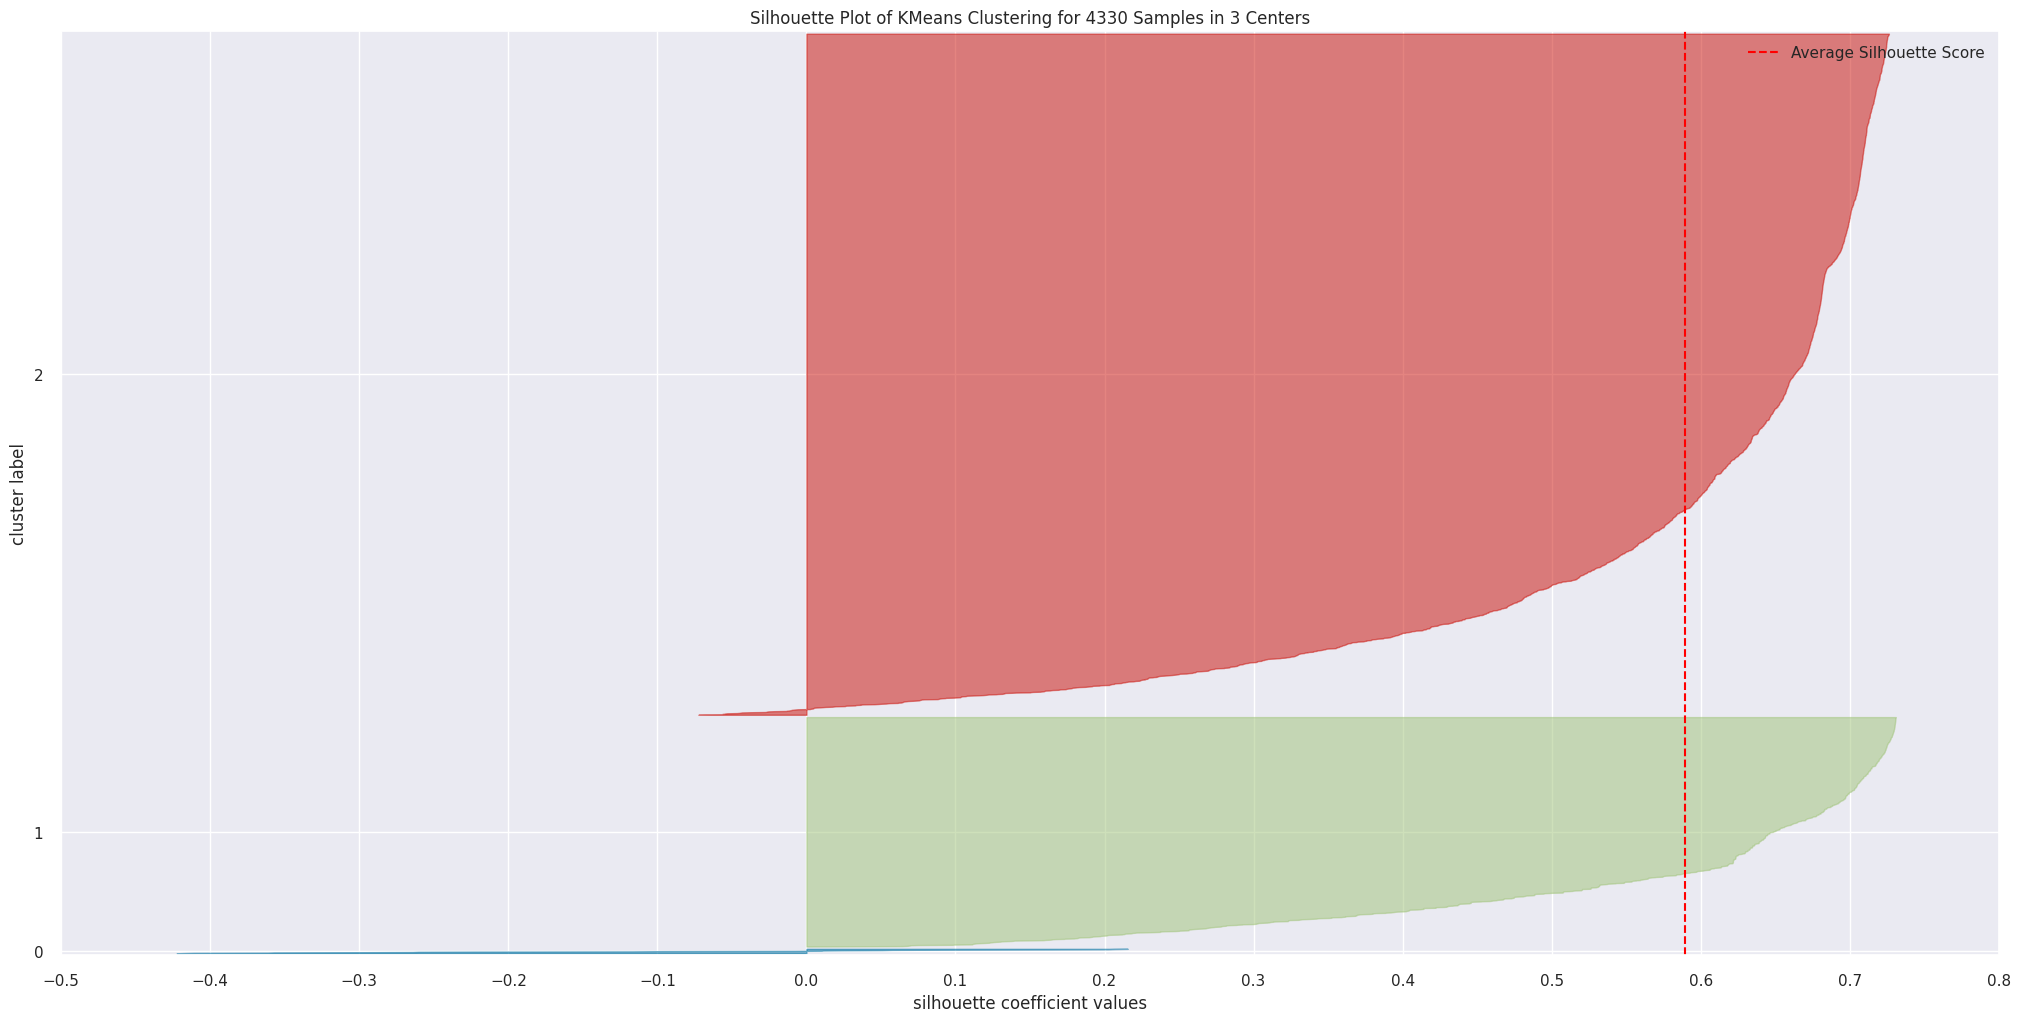

In [65]:
# Silhouette Analysis
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df8)
visualizer.finalize()

## 9.2 2d plot

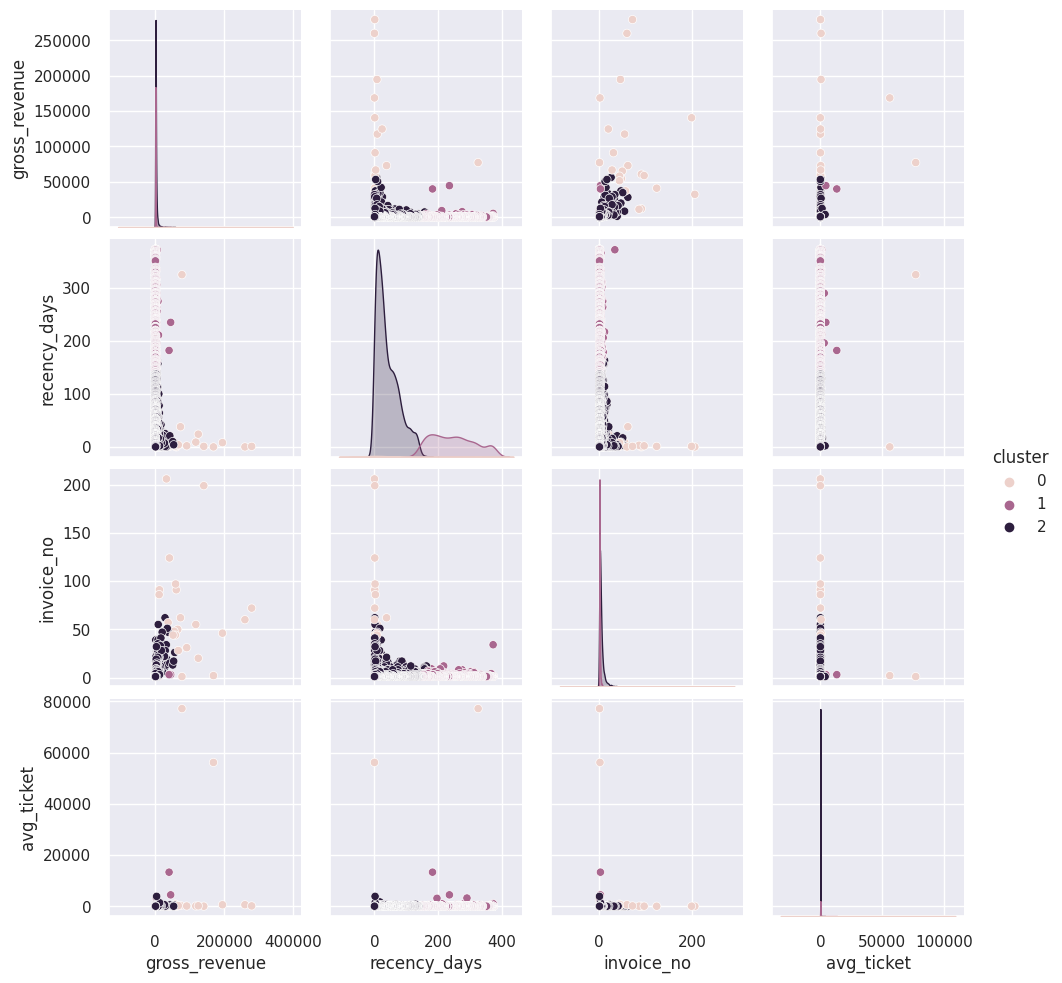

In [66]:
# Pair plot
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

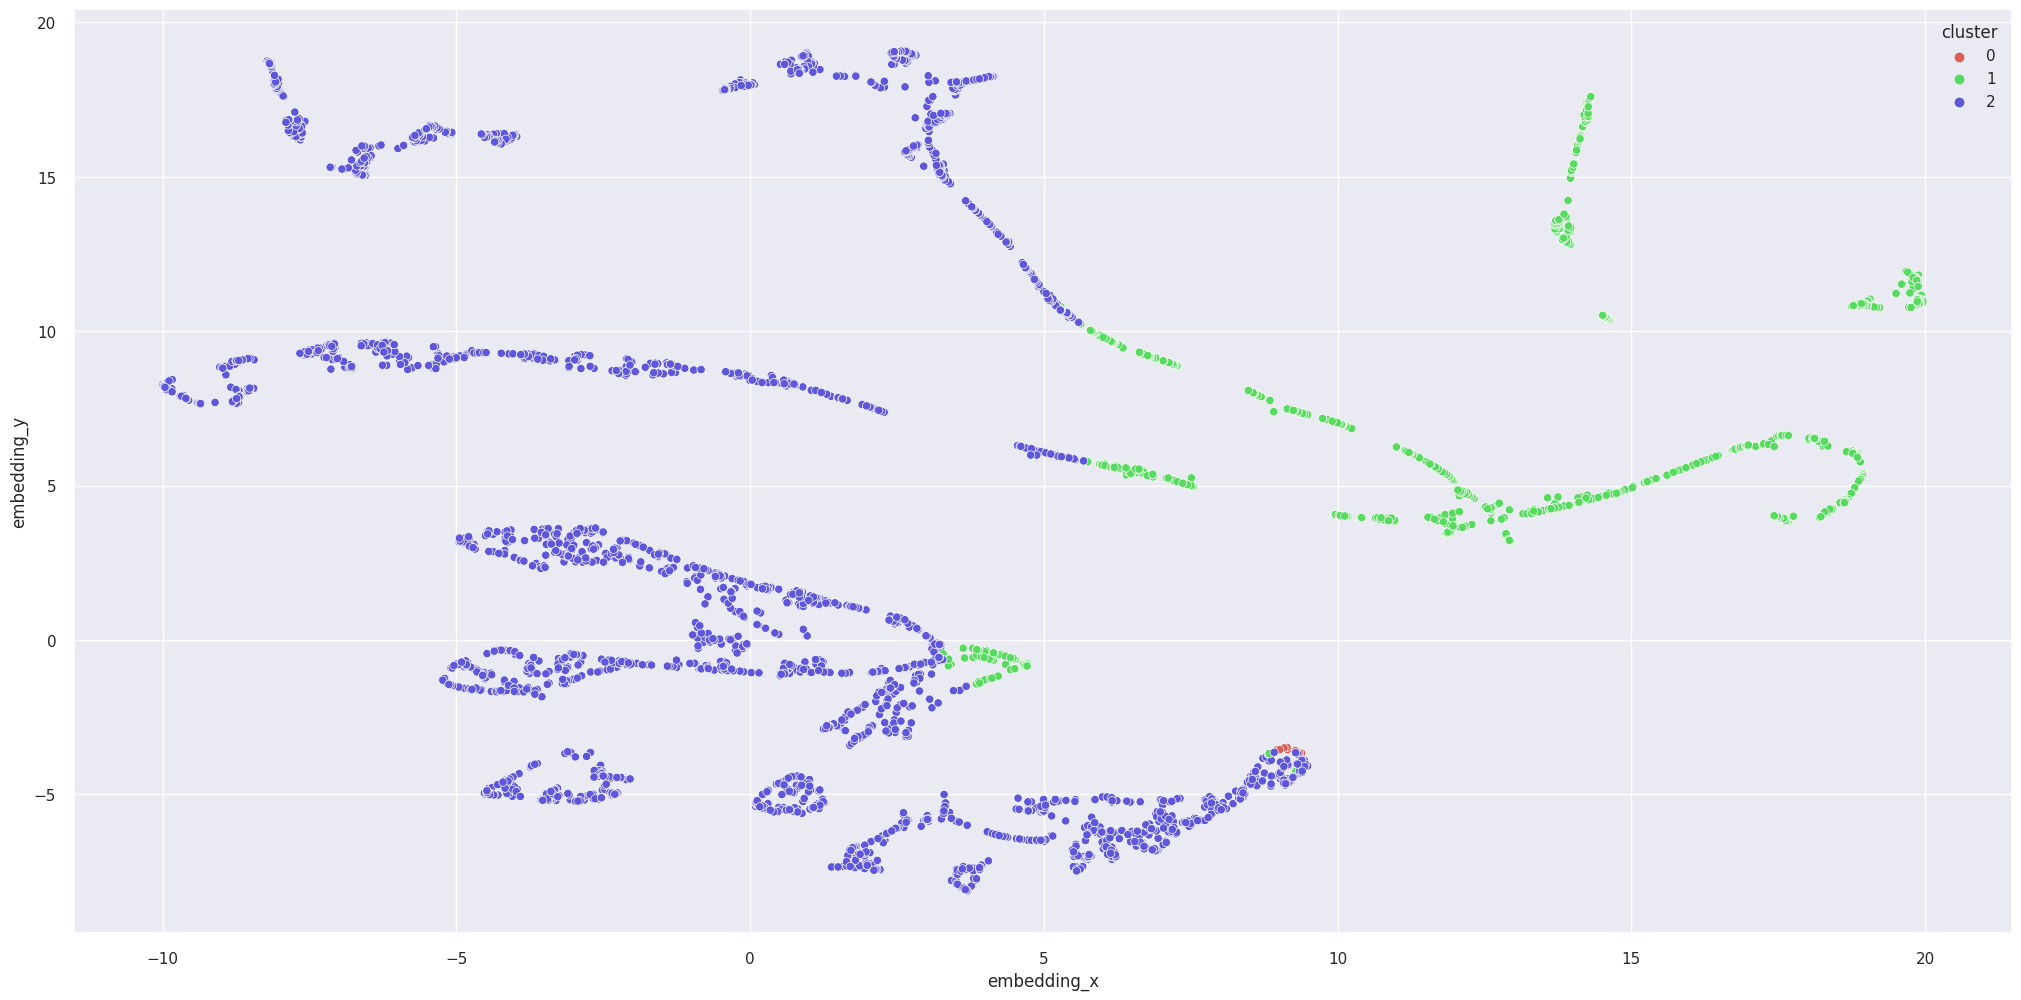

In [67]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df8)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2 Cluster Profile

In [68]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id']/df_cluster['customer_id'].sum()*100

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_avg_recency_days= df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['cluster', 'avg_ticket']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,22,0.508083,94286.856364,19.772727,68.818182,6223.528694
1,1,1086,25.080831,554.956133,246.447514,1.570902,55.265607
2,2,3222,74.411085,1889.122945,40.685599,4.712601,30.285700


### Cluster 01: (Candidato à Insider)
    - Número de customers: 22 (0,50% dos costumers)
    - Recência em média: 20 dias
    - Compras em média: 68 compras
    - Receita em média: £94.286,85
    - Ticket médio de: £6.223,53
    
### Cluster 02:
    - Número de customers: 1086 (25,08% dos costumers)
    - Recência em média: 246 dias
    - Compras em média: 2 compras
    - Receita em média: £5554,96
    - Ticket médio de: £55,27

### Cluster 03:
    - Número de customers: 3222 (74,41% dos costumers)
    - Recência em média: 41 dias
    - Compras em média: 5 compras
    - Receita em média: £1.889,12
    - Ticket médio de: £30,29

# 10.0 DEPLOY TO PRODUCTION